In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
images = tf.data.Dataset.list_files('dataset/images/*.jpg')

In [3]:
images.as_numpy_iterator().next()

b'dataset\\images\\FlightAltitude__1.6m_TemperatureInCenter__31C.jpg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)

In [6]:
images.as_numpy_iterator().next()

array([[[23, 23, 23],
        [21, 21, 21],
        [22, 22, 22],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]],

       [[21, 21, 21],
        [22, 22, 22],
        [21, 21, 21],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]],

       [[19, 19, 19],
        [21, 21, 21],
        [20, 20, 20],
        ...,
        [31, 31, 31],
        [31, 31, 31],
        [31, 31, 31]],

       ...,

       [[22, 22, 22],
        [22, 22, 22],
        [20, 20, 20],
        ...,
        [41, 41, 41],
        [38, 38, 38],
        [33, 33, 33]],

       [[23, 23, 23],
        [22, 22, 22],
        [21, 21, 21],
        ...,
        [30, 30, 30],
        [30, 30, 30],
        [35, 35, 35]],

       [[24, 24, 24],
        [22, 22, 22],
        [23, 23, 23],
        ...,
        [28, 28, 28],
        [24, 24, 24],
        [28, 28, 28]]], dtype=uint8)

In [7]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [8]:
image_generator = images.batch(4).as_numpy_iterator()

In [9]:
plot_images = image_generator.next()

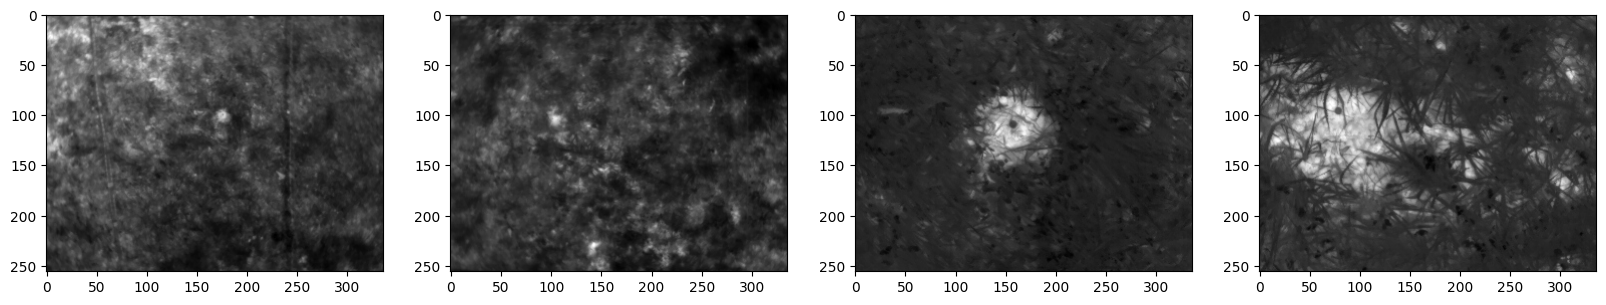

In [10]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [11]:
import albumentations as alb

In [12]:
augmentor =alb.Compose([alb.RandomCrop(width=330, height=250),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast (p=0.2),
                        alb. RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [13]:
img=cv2.imread(os.path.join('dataset/images','FlightAltitude__3.1m_TemperatureInCenter__30C.jpg'))
img.shape

(256, 336, 3)

In [14]:
with open('dataset/labels/FlightAltitude__3.1m_TemperatureInCenter__30C.json', 'r') as f:
    label=json.load(f)

In [15]:
label['shapes'][0]['points']

[[183.21167883211677, 112.76277372262774],
 [217.15328467153282, 171.15693430656935]]

In [16]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]
coords=list(np.divide(coords,[336,256,336,256]))
coords

[0.5452728536670142,
 0.4404795848540146,
 0.6462895377128953,
 0.6685817746350365]

In [17]:
augmented=augmentor(image=img, bboxes=[coords], class_labels=['Landmine'])

In [18]:
augmented['image']

array([[[28, 42, 38],
        [24, 38, 34],
        [36, 50, 46],
        ...,
        [27, 41, 37],
        [25, 39, 35],
        [23, 37, 33]],

       [[29, 43, 39],
        [25, 39, 35],
        [36, 50, 46],
        ...,
        [29, 43, 39],
        [27, 41, 37],
        [23, 37, 33]],

       [[25, 39, 35],
        [25, 39, 35],
        [33, 47, 43],
        ...,
        [31, 45, 41],
        [26, 40, 36],
        [27, 41, 37]],

       ...,

       [[23, 37, 33],
        [16, 30, 26],
        [ 9, 23, 19],
        ...,
        [35, 49, 45],
        [37, 51, 47],
        [35, 49, 45]],

       [[23, 37, 33],
        [14, 28, 24],
        [ 9, 23, 19],
        ...,
        [34, 48, 44],
        [33, 47, 43],
        [31, 45, 41]],

       [[25, 39, 35],
        [11, 25, 21],
        [11, 25, 21],
        ...,
        [33, 47, 43],
        [32, 46, 42],
        [31, 45, 41]]], dtype=uint8)

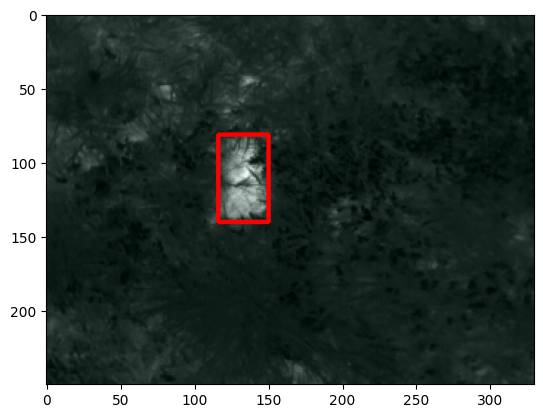

In [19]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[330,250]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[330,250]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [20]:
for image in os.listdir(os.path.join('dataset/images/')):
  img=cv2.imread(os.path.join('dataset/images/', image))
  coords=[0,0,0.00001,0.00001]
  label_path=os.path.join('dataset/labels/',f'{image.split(".")[0]}.{image.split(".")[1]}.json')
  if os.path.exists(label_path):
    with open(label_path, 'r') as f:
      label=json.load(f)
    coords[0]=label['shapes'][0]['points'][0][0]
    coords[1]=label['shapes'][0]['points'][0][1]
    coords[2]=label['shapes'][0]['points'][1][0]
    coords[3]=label['shapes'][0]['points'][1][1]
    coords=list(np.divide(coords,[336,256,336,256]))
  try:
    for x in range(30):
      augmented=augmentor(image=img, bboxes=[coords], class_labels=['Landmine'])
      cv2.imwrite(os.path.join('dataset/augmented_data/images', f'{image.split(".")[0]}.{image.split(".")[1]}.{x}.jpg'), augmented['image'])
      annotation={}
      annotation['image'] = image
      if os.path.exists(label_path):
        if len(augmented['bboxes']) == 0:
          annotation ['bbox'] = [0,0,0,0]
          annotation['class'] = 0
        else:
          annotation['bbox'] = augmented['bboxes'][0]
          annotation['class']=1
      else:
        annotation['bbox'] = [0,0,0,0]
        annotation['class'] = 0

      with open(os.path.join('dataset/augmented_data/labels', f'{image.split(".")[0]}.{image.split(".")[1]}.{x}.json'), 'w') as f:
        json.dump(annotation, f)

  except Exception as e:
    print(e)
